# Assignment 6 - Group Assignment 1

## A bit of info before you start.


> ***First and foremost, dont use AI to code. Use it to understand and then write code yourself. Use AI to verify if the code you wrote it correct, that will help you learn far far more.***

> ***Use cv2 functions only or atleast wherever possible.***

> **This assignment marks 1/3rd of your project. And hence, it is the first part of the final submission from your team.**







## Create a DataLoader Class

Use the pytorch docs sent on group and deepen your understanding using sample practice, or even AI.

Finally, create a dataloader for the Fruits-360 dataset ( https://www.kaggle.com/datasets/moltean/fruits ).
In <code>__getitem__</code> , include the processing to create LBP image, canny image, and find the 6 color features and 6 shape features.
Best implementation should include a proper division of tasks between the method itself and utility functions.
Also brainstorm about the data structures you use to process and pass the info. Use cv2 functions for best performance.

In [1]:
def lbp_image(gray):
    lbp = np.zeros_like(gray, dtype=np.uint8)

    neighbors = [(-1,-1), (-1,0), (-1,1),
                 (0,1), (1,1), (1,0),
                 (1,-1), (0,-1)]

    for idx, (dy, dx) in enumerate(neighbors):
        shifted = np.roll(np.roll(gray, dy, axis=0), dx, axis=1)

        bit = (shifted >= gray).astype(np.uint8)  # 🔑 CAST HERE
        lbp |= (bit << (7 - idx))

    return lbp


In [2]:
def color_mask(img_bgr):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    # White background → low saturation
    lower = np.array([0, 40, 40])
    upper = np.array([180, 255, 255])

    mask = cv2.inRange(hsv, lower, upper)

    kernel = np.ones((5,5), np.uint8)
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)

    return mask
def shape_features(mask):
    contours, _ = cv2.findContours(
        mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE
    )

    if len(contours) == 0:
        return np.zeros(6)

    cnt = max(contours, key=cv2.contourArea)

    area = cv2.contourArea(cnt)
    perimeter = cv2.arcLength(cnt, True)

    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = w / h if h != 0 else 0

    hull = cv2.convexHull(cnt)
    hull_area = cv2.contourArea(hull)
    solidity = area / hull_area if hull_area != 0 else 0

    roundness = (4 * np.pi * area) / (perimeter ** 2 + 1e-6)

    hu = cv2.HuMoments(cv2.moments(cnt)).flatten()
    hu1 = -np.sign(hu[0]) * np.log10(abs(hu[0]) + 1e-6)
    hu2 = -np.sign(hu[1]) * np.log10(abs(hu[1]) + 1e-6)

    return np.array([
        area / (mask.shape[0] * mask.shape[1]),  # normalized area
        aspect_ratio,
        solidity,
        roundness,
        hu1,
        hu2
    ])


In [3]:
def color_features(img_bgr, mask):
    hsv = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2HSV)

    pixels = hsv[mask > 0]
    if len(pixels) == 0:
        return np.zeros(6)

    mean = pixels.mean(axis=0)
    std = pixels.std(axis=0)

    return np.array([
        mean[0], std[0],
        mean[1], std[1],
        mean[2], std[2]
    ])


In [4]:
def canny_image(gray):
    return cv2.Canny(gray, 100, 200)


In [12]:
import os
import cv2
import torch
from torch.utils.data import Dataset
import numpy as np
class Fruits360Dataset(Dataset):
    def __init__(self, root_dir, transform=None):

        self.root_dir = root_dir
        self.transform = transform

        self.samples = []
        self.class_to_idx = {}

        # Create class-to-index mapping
        classes = sorted(os.listdir(root_dir))
        for idx, class_name in enumerate(classes):
            self.class_to_idx[class_name] = idx
            class_path = os.path.join(root_dir, class_name)

            for img_name in os.listdir(class_path):
                img_path = os.path.join(class_path, img_name)
                self.samples.append((img_path, idx))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):

        img_path, label = self.samples[idx]

        # Load image using OpenCV
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

        #Extracting shape features
        mask = color_mask(img)
        shape_feat = shape_features(mask)

        #Exracting color features
        color_feat = color_features(img, mask)

        #For LBP image
        lbp = lbp_image(gray)
        lbp = torch.from_numpy(lbp).float().unsqueeze(0)

        #Extracting canny edges
        canny = canny_image(img)

        return {
            "color_features": torch.tensor(color_feat, dtype=torch.float32),
            "shape_features": torch.tensor(shape_feat, dtype=torch.float32),
            "lbp": torch.tensor(lbp, dtype=torch.float32).unsqueeze(0),
            "canny": torch.tensor(canny, dtype=torch.float32).unsqueeze(0),
            "label": torch.tensor(label)
        }
        return img, label


In [13]:
from google.colab import drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [14]:
import os
dataset = Fruits360Dataset(
    root_dir="/content/drive/MyDrive/Test"
)
labels_map = {v: k for k, v in dataset.class_to_idx.items()}

/tmp/ipython-input-3665276377.py:54: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.detach().clone() or sourceTensor.detach().clone().requires_grad_(True), rather than torch.tensor(sourceTensor).
  "lbp": torch.tensor(lbp, dtype=torch.float32).unsqueeze(0),


Sample type: <class 'dict'>
Keys: dict_keys(['color_features', 'shape_features', 'lbp', 'canny', 'label'])

--- Feature Shapes ---
Color features: torch.Size([6])
Shape features: torch.Size([6])
LBP image: torch.Size([1, 1, 100, 100])
Canny image: torch.Size([1, 100, 100])
Label: tensor(5)

Color Features (6):
Mean Hue       : 115.835365
Std Hue        : 5.4477944
Mean Saturation: 180.61786
Std Saturation : 48.145546
Mean Value     : 99.05924
Std Value      : 39.858192

Shape Features (6):
Normalized Area: 0.5647
Aspect Ratio   : 1.0
Solidity       : 0.8121674
Roundness      : 0.4986978
Hu Moment φ1   : 0.74447435
Hu Moment φ2   : 2.4184608


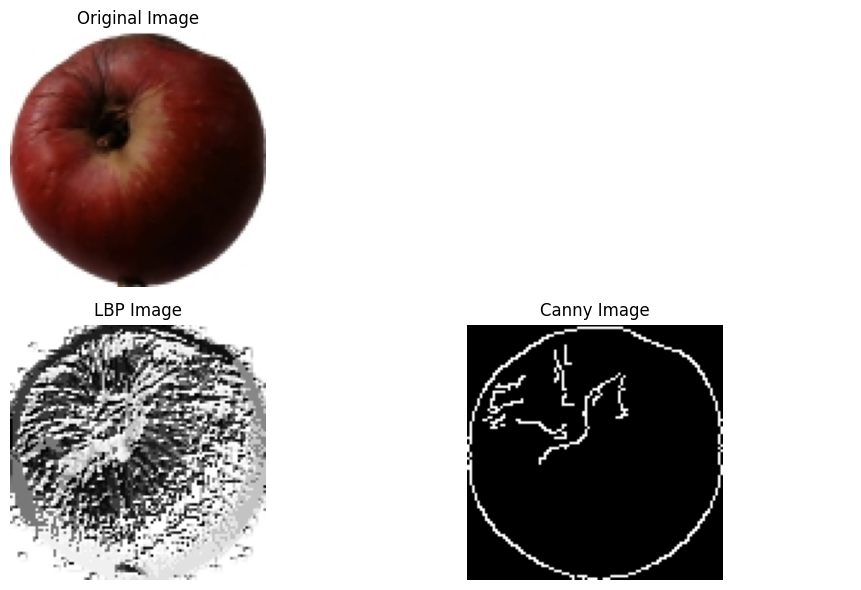

In [18]:
#Sample example
import matplotlib.pyplot as plt
sample = dataset[1000]
img_path, _ = dataset.samples[1000]

img = cv2.imread(img_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)


print("Sample type:", type(sample))
print("Keys:", sample.keys())

print("\nFeature Shapes")
print("Color features:", sample["color_features"].shape)
print("Shape features:", sample["shape_features"].shape)
print("LBP image:", sample["lbp"].shape)
print("Canny image:", sample["canny"].shape)
print("Label:", sample["label"])

color_feat = sample["color_features"].numpy()

print("\nColor Features (6):")
print("Mean Hue       :", color_feat[0])
print("Std Hue        :", color_feat[1])
print("Mean Saturation:", color_feat[2])
print("Std Saturation :", color_feat[3])
print("Mean Value     :", color_feat[4])
print("Std Value      :", color_feat[5])

shape_feat = sample["shape_features"].numpy()

print("\nShape Features (6):")
print("Normalized Area:", shape_feat[0])
print("Aspect Ratio   :", shape_feat[1])
print("Solidity       :", shape_feat[2])
print("Roundness      :", shape_feat[3])
print("Hu Moment φ1   :", shape_feat[4])
print("Hu Moment φ2   :", shape_feat[5])


plt.figure(figsize=(10,6))

plt.subplot(2, 2, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(2, 2, 2)
plt.axis("off")

plt.subplot(2, 2, 3)
plt.imshow(sample["lbp"].squeeze() / 255.0, cmap="gray")
plt.title("LBP Image")
plt.axis("off")

plt.subplot(2, 2, 4)
plt.imshow(sample["canny"].squeeze(), cmap="gray")
plt.title("Canny Image")
plt.axis("off")

plt.tight_layout()
plt.show()

